[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [2]:
import os
from kaggle_secrets import UserSecretsClient

# Ambil secret
user_secrets = UserSecretsClient()
os.environ["ROBOFLOW_API_KEY"] = user_secrets.get_secret("ROBOFLOW_API_KEY")
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Sat Jun  7 01:49:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [5]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 74.5 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 36.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [6]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-06-07 01:51:16--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-06-07 01:51:17 (80.1 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:01<00:00, 41.0MB/s]


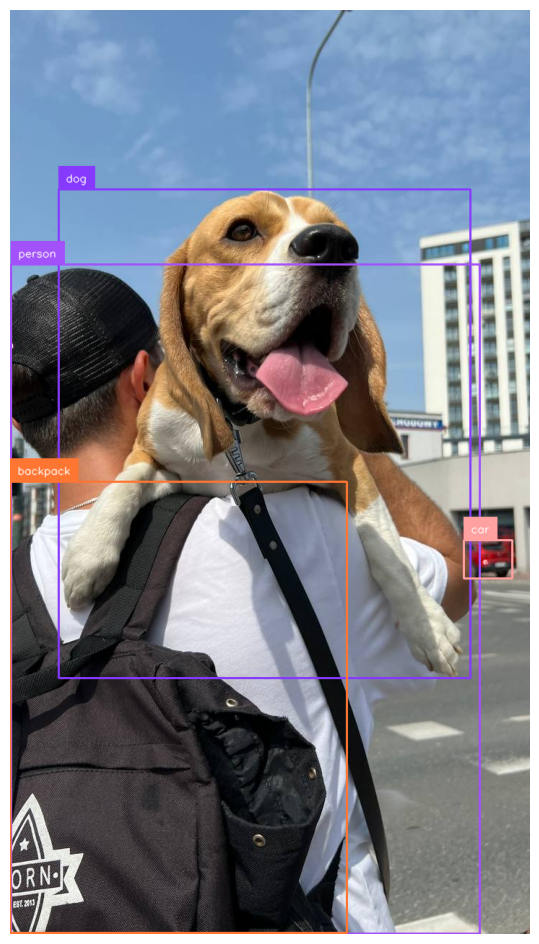

In [7]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:
!pip install roboflow

from roboflow import Roboflow
API_KEY = user_secrets.get_secret("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=API_KEY)
project = rf.workspace("wasteimages-wlpf5").project("trashnet-multiple")
version = project.version(2)
dataset = version.download("yolov12")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to trashnet-multiple-2 in yolov12:: 100%|██████████| 11556/11556 [00:01<00:00, 9510.54it/s] 


In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 6
names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

roboflow:
  workspace: wasteimages-wlpf5
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12m.pt')

results = model.train(
    data=f'{dataset.location}/data.yaml',
    epochs=70,
    imgsz=640,
    batch=16,
    mosaic=1.0,          # tambahkan ini
    mixup=0.2,           # dan ini
    copy_paste=0.2,      # dan ini
    patience=20          # early stopping opsional
)


100%|██████████| 38.0M/38.0M [00:05<00:00, 7.65MB/s]

New https://pypi.org/project/ultralytics/8.3.151 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov12m.pt, data=/kaggle/working/trashnet-multiple-2/data.yaml, epochs=70, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

100%|██████████| 755k/755k [00:00<00:00, 183MB/s]
E0000 00:00:1749261292.991232      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749261293.042278      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2, 1, 2]         
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    147968  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2, 1, 4]        
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2664960  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 26.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/trashnet-multiple-2/train/labels... 5049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5049/5049 [00:03<00:00, 1491.62it/s]


train: New cache created: /kaggle/working/trashnet-multiple-2/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3031, len(boxes) = 8236. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /kaggle/working/trashnet-multiple-2/valid/labels... 481 images, 0 backgrounds, 0 corrupt: 100%|██████████| 481/481 [00:00<00:00, 799.29it/s]


val: New cache created: /kaggle/working/trashnet-multiple-2/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 236, len(boxes) = 730. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 131 weight(decay=0.0), 138 weight(decay=0.0005), 137 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      11.5G      1.184      2.058      1.661         27        640: 100%|██████████| 316/316 [06:06<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        481        730      0.269      0.307      0.269      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      11.2G      1.274       2.04      1.739         33        640: 100%|██████████| 316/316 [06:02<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]

                   all        481        730      0.281      0.453      0.308      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      11.3G      1.221      1.984      1.704         36        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]

                   all        481        730       0.49      0.432      0.424      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      11.2G      1.189      1.882      1.662         41        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]

                   all        481        730      0.423      0.472      0.414      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      11.2G      1.114      1.747      1.602         51        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]

                   all        481        730       0.61      0.558      0.573      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      11.2G       1.07      1.675      1.566         21        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]

                   all        481        730      0.609      0.512      0.538      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      11.3G      1.045      1.611      1.542         41        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.669      0.531       0.59      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      11.2G      1.021      1.574      1.522         48        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]

                   all        481        730      0.691      0.524       0.57      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      11.2G      1.003       1.51       1.51         66        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]

                   all        481        730      0.604      0.568       0.57      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      11.2G     0.9712      1.462      1.479         27        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.719      0.562      0.652      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      11.2G     0.9704      1.444      1.482         68        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]

                   all        481        730      0.765      0.518      0.649      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      11.3G      0.949      1.391      1.464         51        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.738      0.646      0.724      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      11.3G      0.933      1.377      1.451         22        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.736      0.608      0.715      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      11.3G     0.9334      1.344      1.446         57        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]

                   all        481        730      0.718      0.605      0.641       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      11.2G      0.895      1.278      1.429         36        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.752      0.655      0.752      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      11.2G     0.9031      1.268      1.421         39        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730       0.77      0.591      0.697      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      11.2G     0.9006      1.271      1.418         32        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.687      0.667      0.741      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      11.2G     0.8929      1.247      1.417         45        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.807       0.59      0.727      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      11.2G     0.8808      1.206      1.401         32        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730       0.85       0.63      0.783      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      11.2G     0.8685      1.172      1.399         68        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.826      0.604      0.763       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      11.2G     0.8637      1.184      1.395         38        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.811      0.648      0.778      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      11.2G     0.8653      1.152      1.383         52        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730        0.8      0.657      0.788      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      11.2G     0.8499      1.135      1.382         66        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.845      0.662      0.808      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      11.2G     0.8381      1.111      1.375         37        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.813       0.72      0.815      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      11.2G     0.8422      1.103      1.375         32        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730        0.8      0.739      0.843      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      11.2G     0.8455      1.093      1.376         35        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.763      0.729      0.839      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      11.2G     0.8145      1.057      1.354         37        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730       0.82      0.764      0.857       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      11.2G     0.8209       1.05      1.353         42        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730       0.84       0.79      0.866       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      11.2G     0.8153      1.036      1.352         40        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.837      0.801      0.883      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      11.2G     0.8213       1.03       1.35         49        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.805      0.772       0.86       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      11.2G     0.8104      1.003      1.345         30        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730       0.88      0.809      0.894      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      11.3G     0.7888     0.9807      1.333         29        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.837      0.803       0.89      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      11.2G     0.7836     0.9749       1.33         51        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.766      0.814      0.872      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      11.2G     0.7712     0.9481      1.317         31        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.864      0.796      0.886      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      11.3G     0.7798      0.944      1.324         29        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.858      0.779      0.877      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      11.1G     0.7783     0.9289      1.316         65        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.908      0.807      0.901      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      11.3G     0.7803     0.9194      1.317         67        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.845       0.84      0.911      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      11.2G     0.7573     0.8913      1.308         51        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.865      0.834      0.913      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      11.3G     0.7579      0.868      1.306         29        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.879      0.845      0.911      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      11.2G     0.7522     0.8663      1.302         38        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.909      0.834       0.92      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      11.2G     0.7501     0.8584      1.298         38        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.881      0.853      0.923      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      11.3G     0.7446     0.8534      1.296         40        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.907      0.843      0.924      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      11.2G     0.7509     0.8377      1.293         55        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.913      0.854      0.931      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      11.2G     0.7337      0.835      1.289         48        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.908      0.862      0.928       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      11.2G     0.7198     0.8005      1.281         31        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.896       0.85      0.926      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      11.2G     0.7079     0.7866      1.271         40        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.921      0.859      0.938      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      11.2G     0.7086     0.7725      1.269         32        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.905      0.873      0.937      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      11.3G     0.6946     0.7618      1.264         53        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.891      0.859      0.932      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      11.2G     0.7202     0.7785      1.275         26        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730       0.93      0.889      0.949       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      11.3G     0.7083     0.7613      1.266         55        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.914      0.871      0.942      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      11.2G     0.6984     0.7413      1.258         35        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730      0.919      0.869      0.937      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      11.2G     0.7001     0.7448      1.264         30        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.909      0.884       0.94       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      11.2G     0.7015     0.7433      1.264         54        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.913      0.889      0.942      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      11.3G     0.7021     0.7351      1.262         51        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730      0.922      0.905      0.948      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      11.2G     0.6624     0.7014       1.24         33        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.936      0.885      0.945      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      11.2G      0.663      0.688      1.235         57        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730      0.925      0.898      0.952      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      11.3G     0.6778     0.6982      1.239         33        640: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730      0.912      0.905      0.948       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      11.2G     0.6642     0.6754      1.236         91        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730      0.949      0.879      0.951       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      11.3G     0.6482     0.6588      1.227         26        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730      0.933      0.877      0.949      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      11.3G     0.6821     0.6816       1.24         37        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730      0.938      0.893      0.955      0.835


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      11.2G     0.5593     0.3867      1.215          9        640: 100%|██████████| 316/316 [06:00<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.925      0.884       0.95      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      11.3G     0.5346      0.355      1.194          9        640: 100%|██████████| 316/316 [05:59<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.941      0.902      0.947      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      11.2G     0.5174      0.327      1.179          9        640: 100%|██████████| 316/316 [05:59<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730      0.957      0.884      0.952      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      11.2G     0.5029     0.3251      1.171         10        640: 100%|██████████| 316/316 [05:59<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730      0.945      0.901      0.954      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      11.2G     0.5058     0.3231      1.169         25        640: 100%|██████████| 316/316 [05:59<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        481        730      0.942      0.912      0.956      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      11.2G     0.4906     0.3125      1.157         42        640: 100%|██████████| 316/316 [05:59<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

                   all        481        730       0.94      0.917      0.957      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      11.2G     0.4803     0.3046      1.148          9        640: 100%|██████████| 316/316 [05:59<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]

                   all        481        730      0.935      0.915      0.959      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      11.2G     0.4731     0.2939      1.139          9        640: 100%|██████████| 316/316 [05:58<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]

                   all        481        730       0.95      0.906      0.961      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      11.2G     0.4637     0.2875      1.136          9        640: 100%|██████████| 316/316 [05:58<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]

                   all        481        730      0.947      0.915      0.961      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      11.2G     0.4609     0.2792      1.131          9        640: 100%|██████████| 316/316 [05:58<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        481        730      0.959        0.9      0.962      0.857



70 epochs completed in 7.220 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 39.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 39.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12m summary (fused): 402 layers, 19,581,154 parameters, 0 gradients, 59.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


                   all        481        730       0.95      0.906      0.961      0.861
             cardboard         94        101      0.963      0.921      0.989      0.928
                 glass         88        106      0.944      0.955      0.983      0.884
                 metal         68         79      0.987      0.944      0.985      0.923
                 paper         66         68      0.959      0.926      0.987      0.934
               plastic        141        259       0.92      0.846       0.92      0.759
                 trash         49        117      0.926      0.846      0.905      0.737


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 15.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					  train_batch18960.jpg
confusion_matrix_normalized.png			  train_batch18961.jpg
confusion_matrix.png				  train_batch18962.jpg
events.out.tfevents.1749261304.16ee8eb46234.35.0  train_batch1.jpg
F1_curve.png					  train_batch2.jpg
labels_correlogram.jpg				  val_batch0_labels.jpg
labels.jpg					  val_batch0_pred.jpg
P_curve.png					  val_batch1_labels.jpg
PR_curve.png					  val_batch1_pred.jpg
R_curve.png					  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


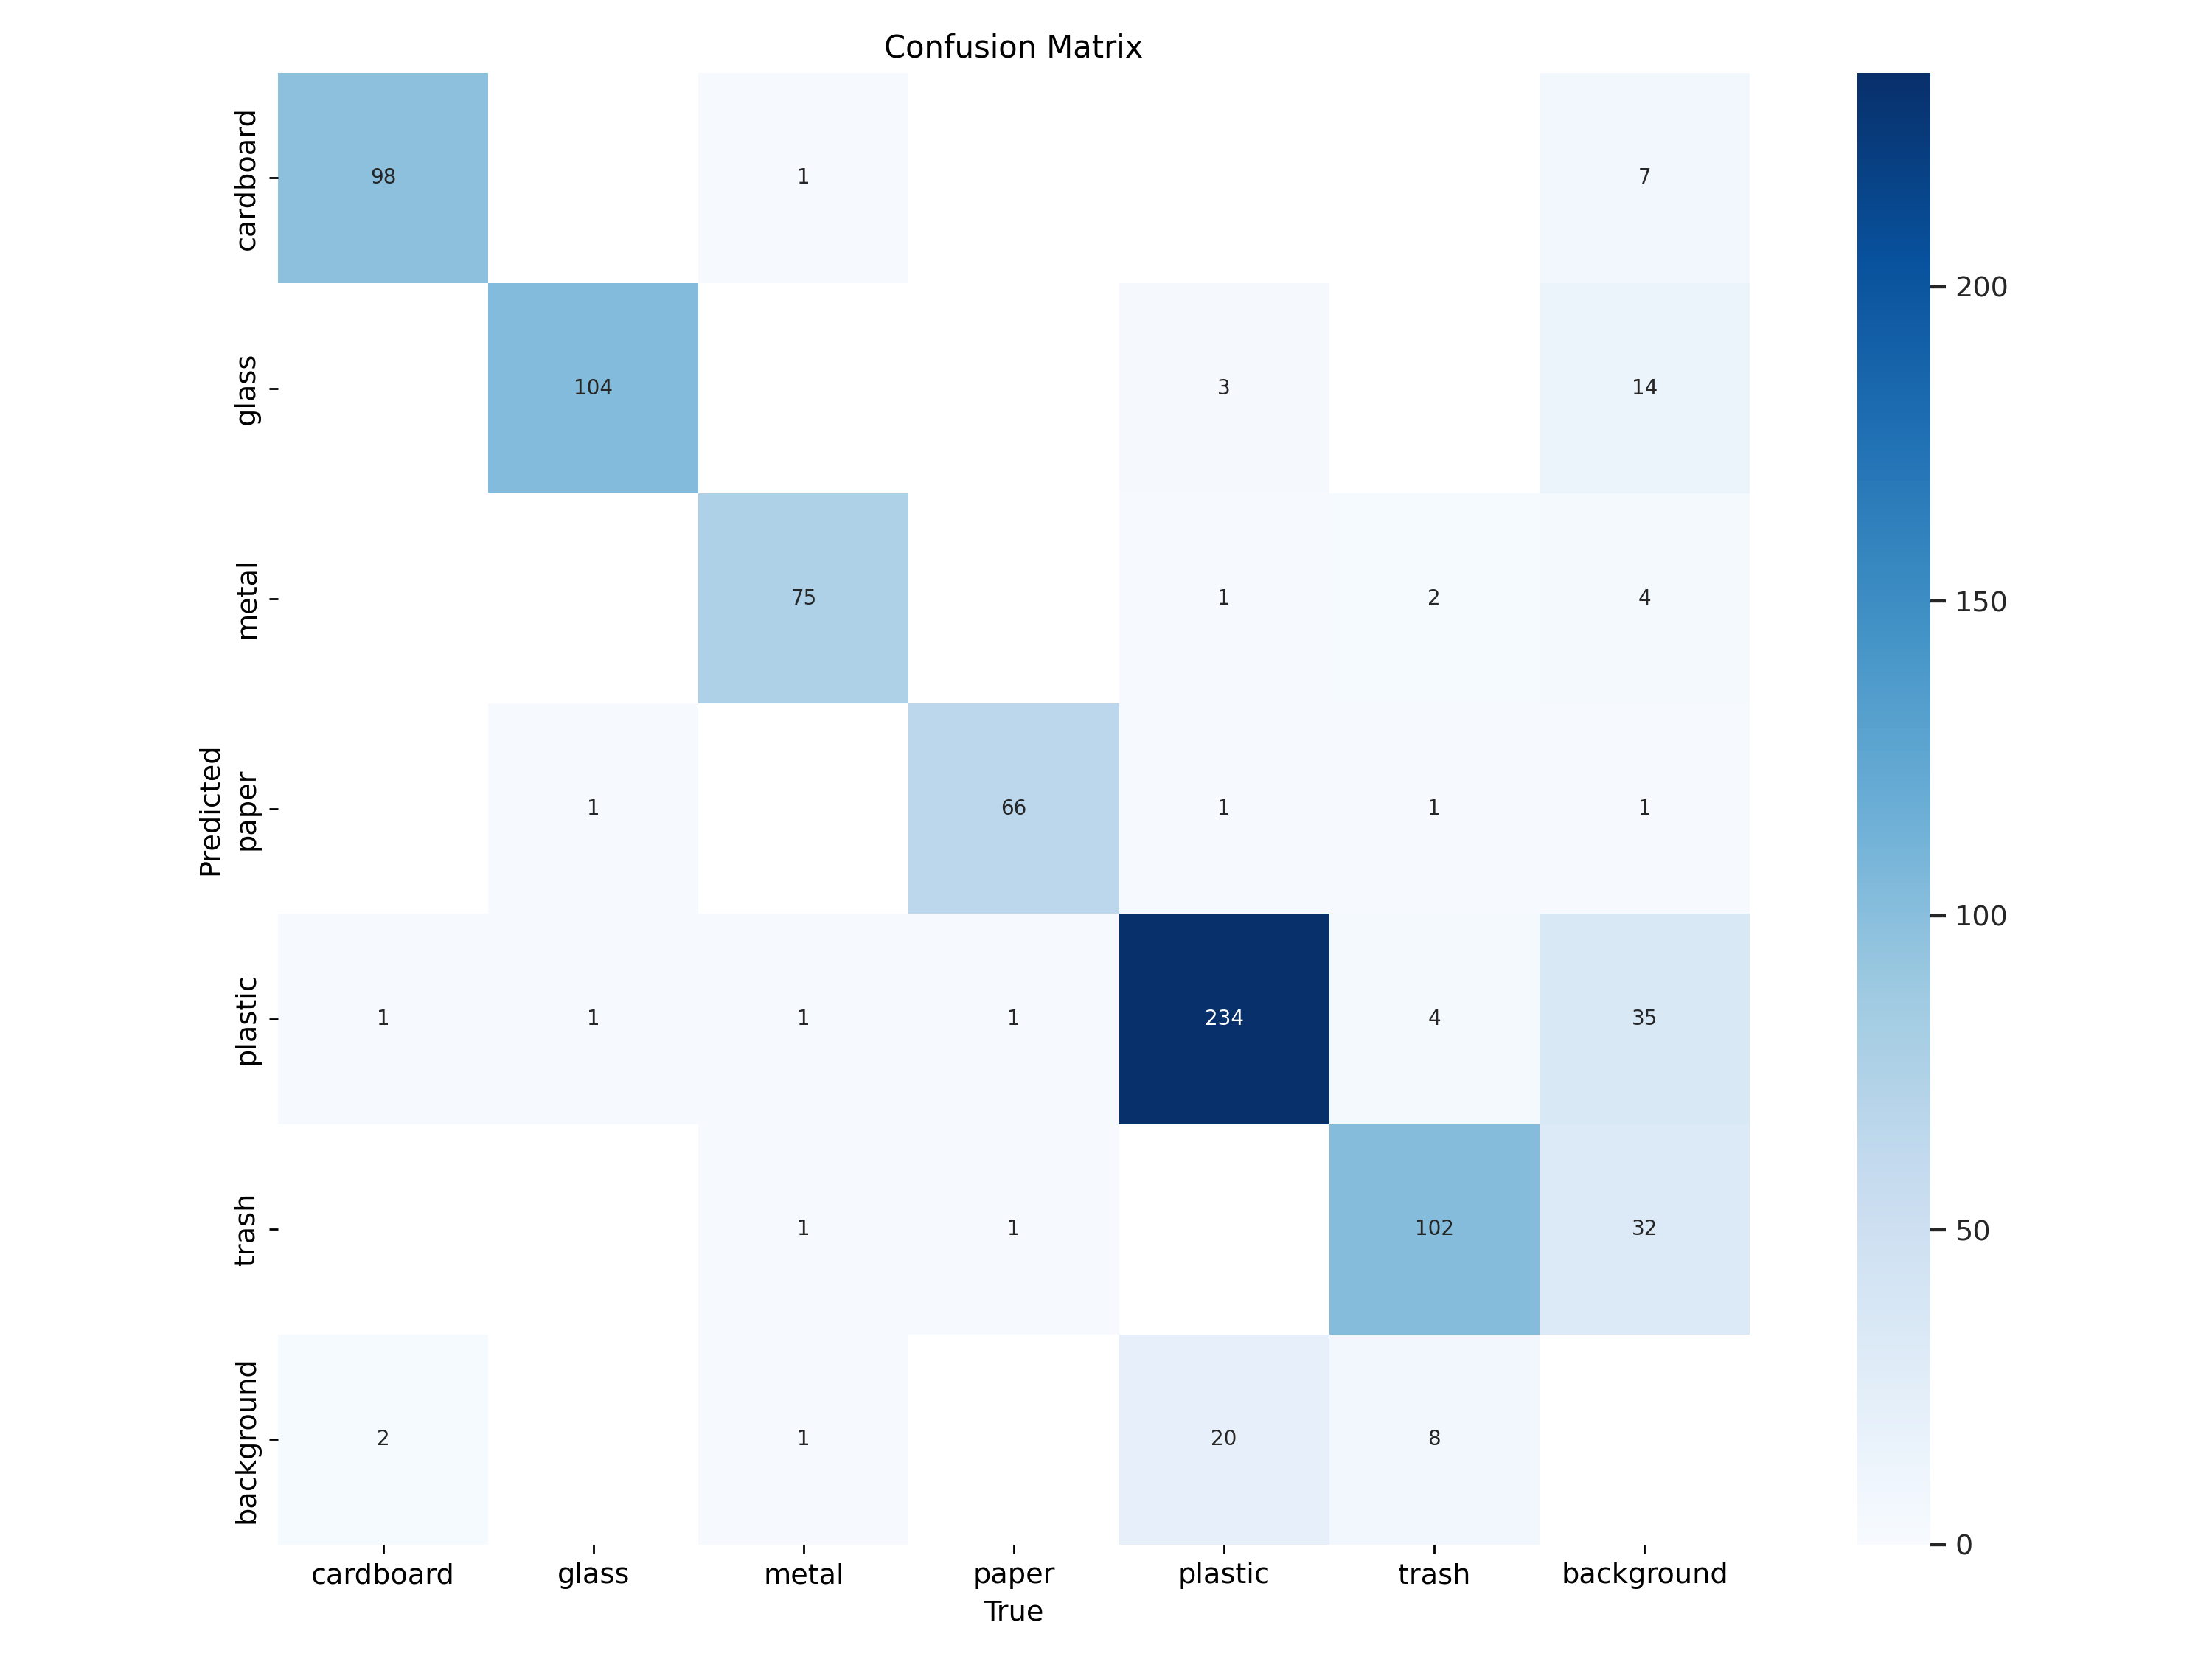

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

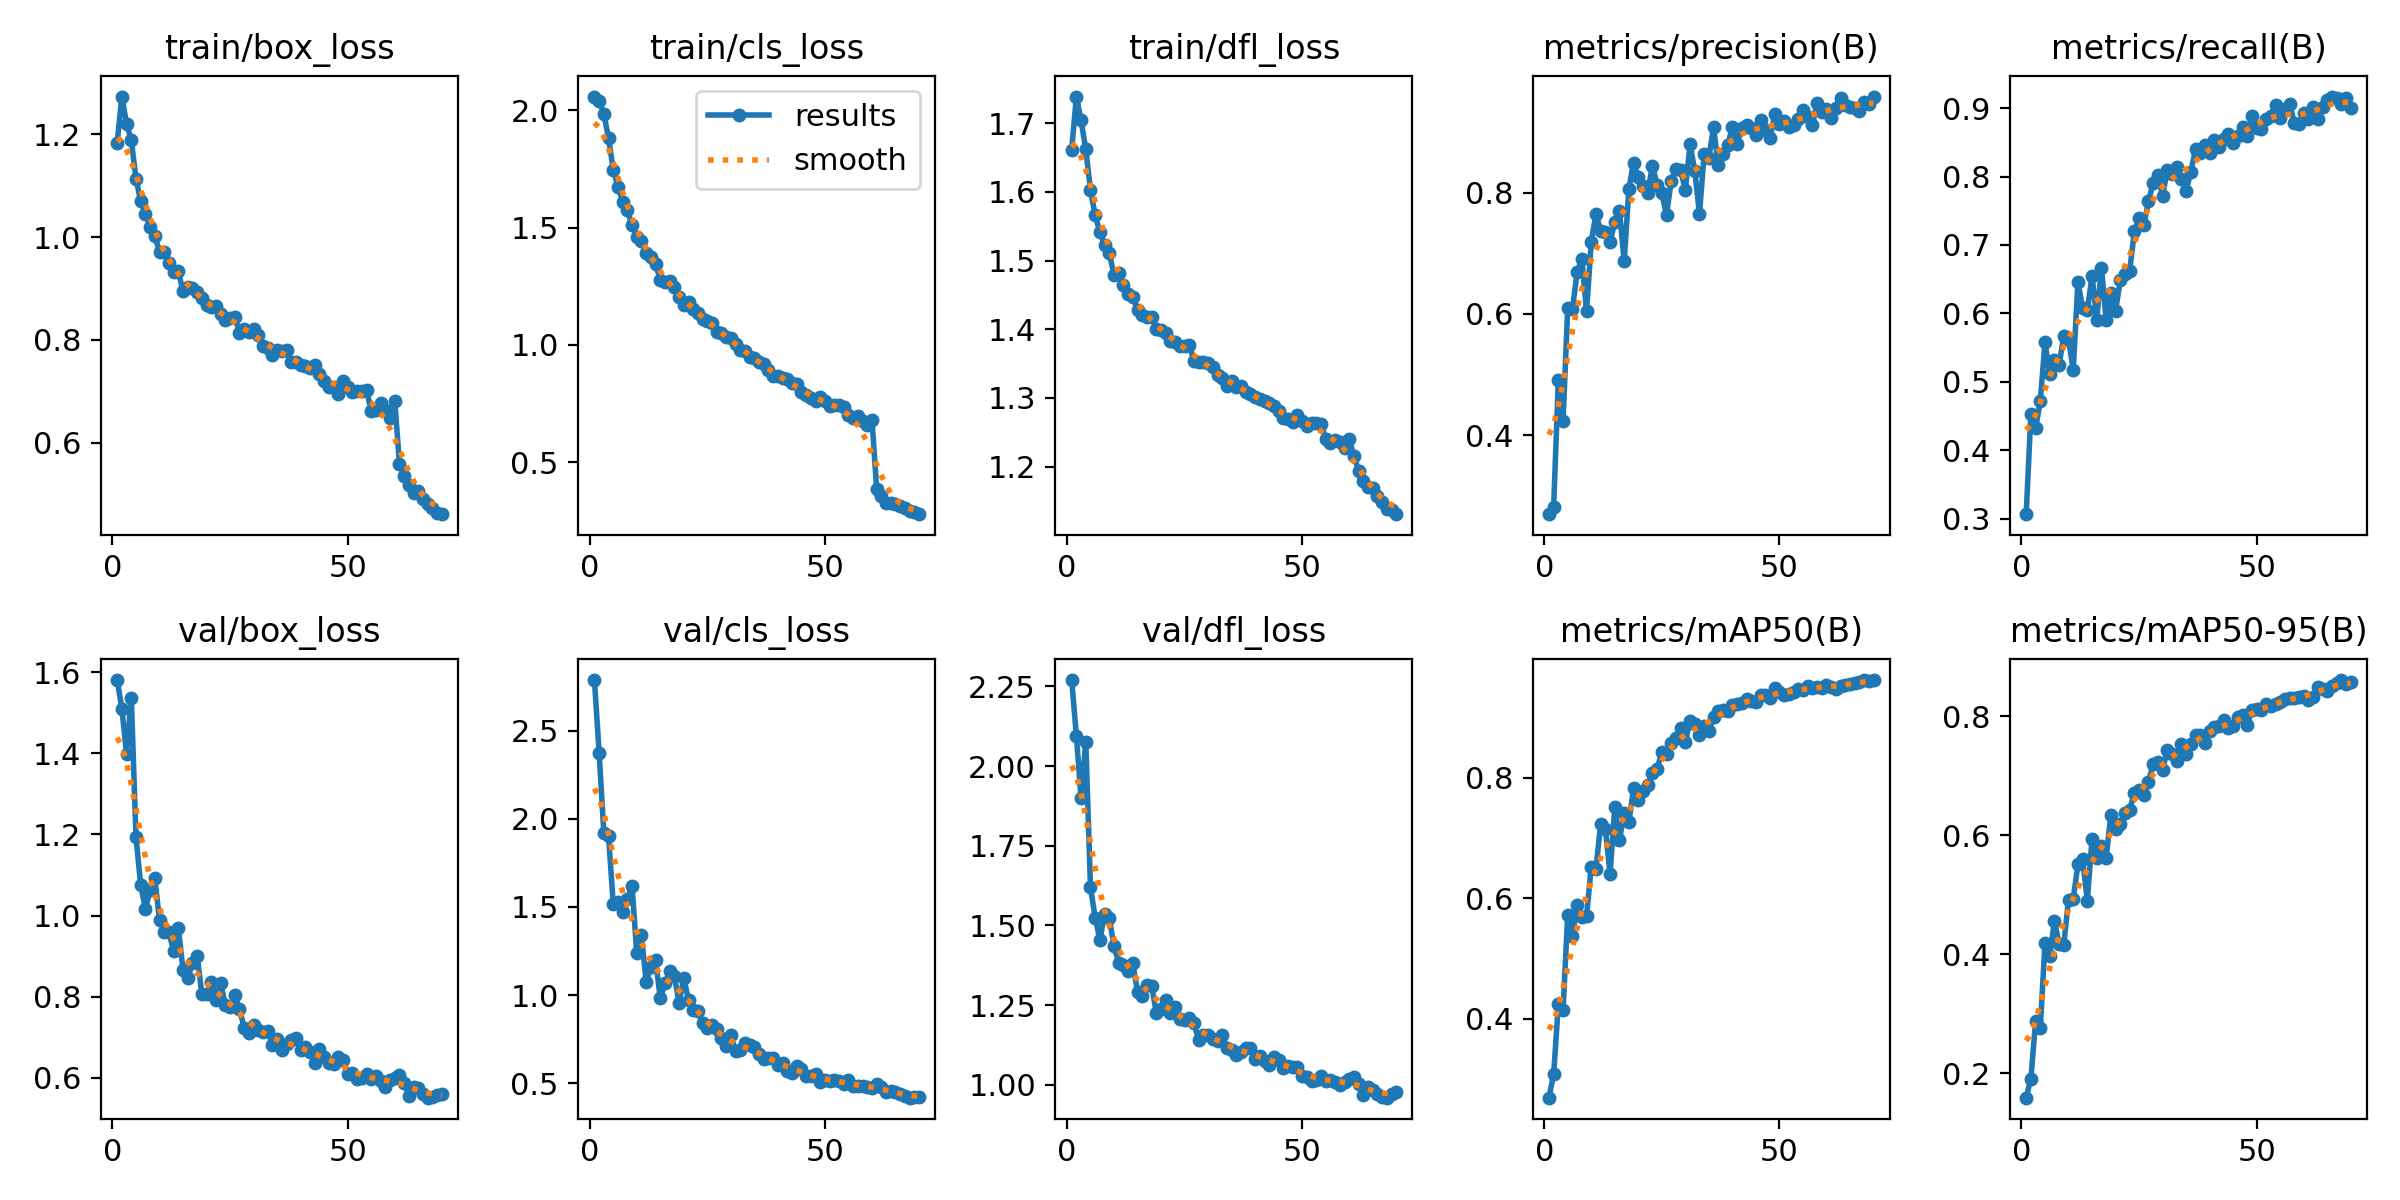

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.77669481657484
mAP 50 0.8663171065376184
mAP 75 0.841735848657898


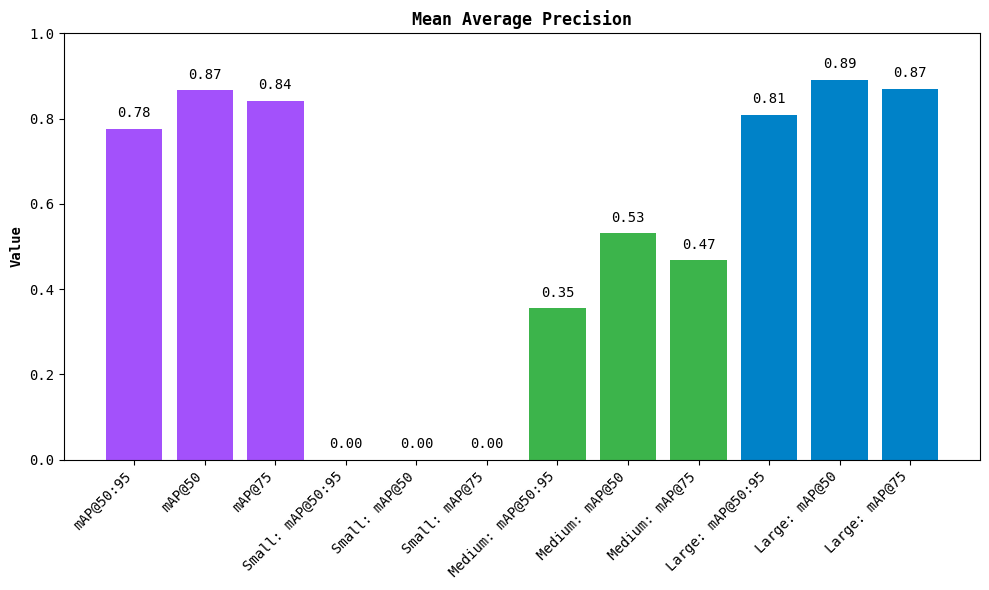

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

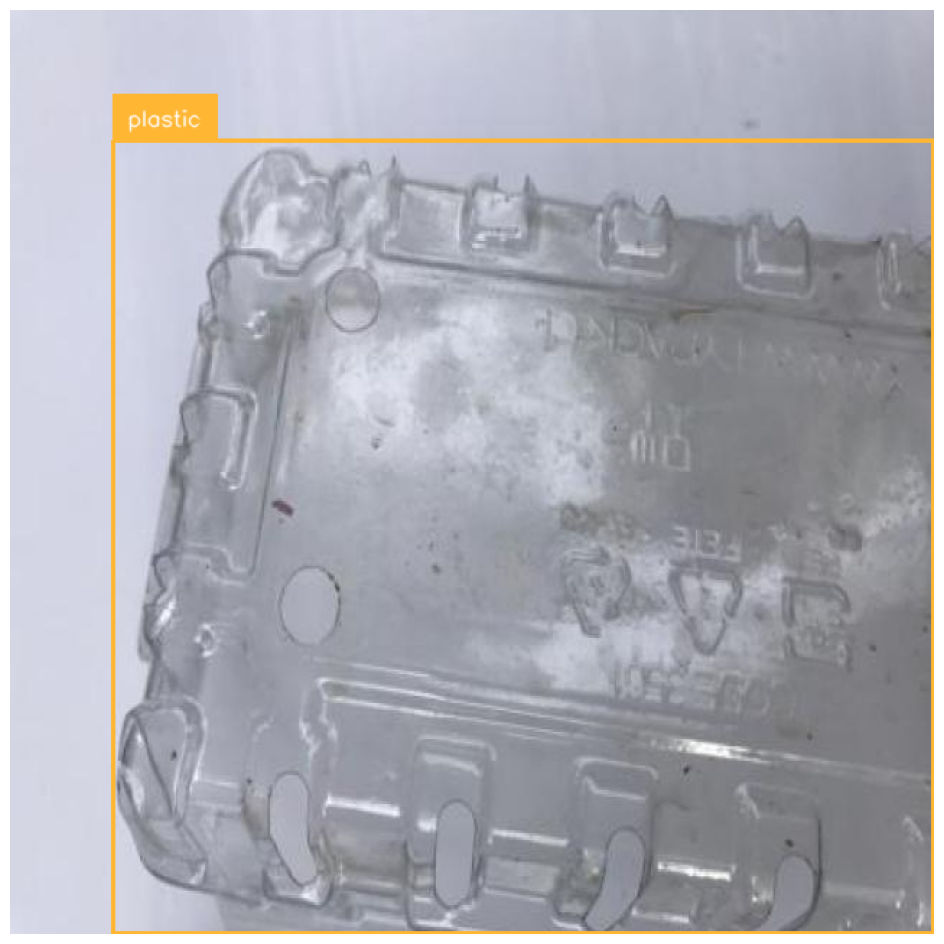

In [37]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

# SAVE MODEL

In [23]:
import shutil

# Kompres folder ke zip
shutil.make_archive('/kaggle/working/weights', 'zip', '/kaggle/working/runs/detect/train/weights')

'/kaggle/working/weights.zip'

In [28]:
!pip install -U -q PyDrive


In [29]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autentikasi Google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [30]:
# Upload weights.zip
upload_file = drive.CreateFile({'title': 'weights.zip'})
upload_file.SetContentFile('/kaggle/working/weights.zip')
upload_file.Upload()
print('Upload selesai, file ada di Google Drive kamu 🎉')


Upload selesai, file ada di Google Drive kamu 🎉


In [40]:
import shutil

shutil.make_archive('/kaggle/working/valid_folder', 'zip', '/kaggle/working/trashnet-multiple-2/valid')


'/kaggle/working/valid_folder.zip'

In [42]:
# Upload file
uploaded = drive.CreateFile({'title': 'valid_folder.zip'})
uploaded.SetContentFile('/kaggle/working/valid_folder.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1RmyPB-wMTNFW4sJpsOFDrb8NdOOYnfPj


In [45]:
from ultralytics import YOLO

# 1. Muat model .pt Anda yang sudah terlatih
model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

# 2. Ekspor model ke format ONNX
model.export(format='onnx')

print("Model berhasil diekspor sebagai 'best.onnx'")

Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLOv12m summary (fused): 402 layers, 19,581,154 parameters, 0 gradients, 59.5 GFLOPs

PyTorch: starting from '//kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (37.9 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.2/146.2 kB 237.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 264.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 306.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 10.9s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming wit

In [46]:
# Upload file
uploaded = drive.CreateFile({'title': 'model.onnx'})
uploaded.SetContentFile('/kaggle/working/runs/detect/train/weights/best.onnx')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1GB4oOHHbZb01-vzvgH-RUyU1BHaIu05o
